In [ ]:
# Google Drive와 마운트
from google.colab import drive
ROOT = '/content/drive'
drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Project Folder 연결
from os.path import join  

MY_GOOGLE_DRIVE_PATH = 'My Drive/Colab Notebooks/hkit301/data'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)
print(PROJECT_PATH)

/content/drive/My Drive/Colab Notebooks/hkit301/data


## 프로젝트 경로 재확인

In [ ]:
%cd "{PROJECT_PATH}"

/content/drive/My Drive/Colab Notebooks/hkit301/data


##### 구글드라이브 및 빅쿼리 프로젝트에 있는 csv파일에서 pandas로 데이터 불러들이기(시간 좀 걸림)

In [ ]:
import pandas as pd
from pandas.io import gbq

# import submission file in Google Drive
submission = pd.read_csv('submission.csv')

# Connect to Google Cloud API and Upload DataFrame
submission.to_gbq(destination_table='jeju_data_ver1.submission', 
                  project_id='cardproject-283503', 
                  if_exists='replace')

# import submission file in Google Drive
train = pd.read_csv('201901-202003.csv')

# Connect to Google Cloud API and Upload DataFrame
train.to_gbq(destination_table='jeju_data_ver1.201901_202003_train', 
                  project_id='cardproject-283503', 
                  if_exists='replace')

1it [00:03,  3.13s/it]
1it [08:52, 532.02s/it]


먼저 구글 코랩 내에서 pandas_profiling을 확인하기 위해 master.zip을 설치한다.
- ref. https://github.com/pandas-profiling/pandas-profiling
- 설치가 끝나면 구글코랩에서 런타임 다시 시작 한다.

In [ ]:
!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip

  Using cached https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
  Created wheel for pandas-profiling: filename=pandas_profiling-2.9.0rc1-py2.py3-none-any.whl size=258106 sha256=6aed075cd3d55b71d2b6c726751038978744f0d9969767f22675f35c9e446305
  Stored in directory: /tmp/pip-ephem-wheel-cache-dzb6_w9w/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
Successfully built pandas-profiling


## (1) XGboost 개요
- 트리기반의 앙상블 학습 알고리즘
- 논문: XGBoost: A Scalable Tree Boosting System
- 가장 좋은 공부는 논문을 빠르게 리뷰하는 것이다.
- Xgboost는 GBM에 기반하고 있지만, 기존의 GBM의 단점을 보완하였다.
- 또하나는 기존 알고리즘의 단점인 과적합 규제(Regularization) 부재 등의 문제를 해결하였다.
- 또다른 장점은, CPU환경에서 병렬학습이 가능해서 기존 GBM보다 학습이 빠르다.
- 속도를 측정하는 방법은 추후 기회가 되면 포스팅을 진행한다.
- 나무 가지치기(Tree Pruning): 쓸모없는 가지는 불필요햔 영양분만 가져간다, 이런 경우에는 가지를 쳐서 영양분이 좋은 곳에 갈 수 있도록 유도한다.
- 마찬가지로, 긍정 이득이 없는 분할을 가지치기 해서 분할 수를 더 줄이는 추가적인 장점이 있다.
- 결손값 자체 처리: XGBoost는 결손값을 자체 처리할 수 있는 기능을 가진다.

## (2) XGboost 설치
- 설치방법은 여러가지가 있다. (Conda, Pypl)
- 자세한 내용은 설치가이드를 참조하기를 바란다.
- 다행히, Google Colab에서는 자유롭게 사용할 수 있다.

In [ ]:
from xgboost import XGBRegressor
import xgboost
print(xgboost.__version__)

0.90


## (3) XGboost 기본 실습
- 본 데이터에서 적용하기 전, 간단하게 회귀모형을 만들고 예측하는 코드를 작성한다.

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_train, X_test, y_train, y_test=train_test_split(x, y, test_size=0.15, random_state = 1)

xgb_reg = XGBRegressor(verbosity=0) 
print(xgb_reg)

xgb_reg.fit(X_train, y_train)
score = xgb_reg.score(X_train, y_train)  
print("Training score: ", score)

y_pred = xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=0)
Training score:  0.9749120480780799
MSE: 7.22


## (4) LightGBM 개요
- LightGBM과 XGBoost의 가장 큰 차이점은 연산속도이다.
- 기존의 GBM계열은 균형 트리 분할 방법(Level Wise)을 사용한다.
- 기존 방식에서는 보통 균형 잡힌 트리(Level Wise)를 채택하는데, 그 이유는 오버피팅에 보다 더 강한 구조를 가질 수 있다고 알려져 있기 때문이다.
- 그러나, 이는 시간이 더 많이 필요하다는 단점이 있다.
- LightGBM은 Leaf 중심 트리 분할 방식을 사용한다.
- 트리의 균형을 맞추지 않고, 최대 손실 값(max delta loss)을 가지는 리프 노드를 지속적으로 분할한다.
- 최대 손실값을 찾아서 리프 노드를 지속적으로 분할해 생성된 규칙 드리를 학습할수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화 할 수 있다.
- 또 다른 특징은, GPU를 지원하고 있고, 병렬 컴퓨팅 기능을 제공하고 있다.
- 이는 대용량 데이터를 학습할 때, 보다 빠르게 학습시킬 수 있음을 의미한다.

## (5) LightGBM 설치
- 설치방법은 OS마다 다르기 때문에 공식 설치 문서를 참조한다.
- 다행히 구글 Colab에서도 lightgbm을 사용할 수 있다.

In [ ]:
import lightgbm
from lightgbm import LGBMRegressor
print(lightgbm.__version__)

2.2.3


## (6) LightGBM 실습
- 본 데이터에서 적용하기 전, 간단하게 회귀모형을 만들고 예측하는 코드를 작성한다.

In [ ]:
# 데이터셋 분리
from sklearn.model_selection import train_test_split

# 데이터 수집
from sklearn.datasets import load_boston

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 데이터 수집
boston = load_boston()
x, y = boston.data, boston.target

# 데이터 분리
X_training, X_testing, y_training, y_testing = train_test_split(x, y, test_size=0.15, random_state = 1)

lgb_reg = LGBMRegressor(verbosity=0) 
print(lgb_reg)

lgb_reg.fit(X_training, y_training)
score = lgb_reg.score(X_training, y_training)  
print("Training score: ", score)

y_pred = lgb_reg.predict(X_testing)
mse = mean_squared_error(y_testing, y_pred)
print("MSE: %.2f" % mse)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
              verbosity=0)
Training score:  0.9799082762820248
MSE: 9.44


# II. 스태킹(Stacking) 알고리즘
- D. H. Wolpert(1992)가 Stacked Generalization이름으로 처음 제안함

- 그후 2015년에 Kaggle 대회에서 소개되면서 퍼지기 시작함
- ref. https://wolpert.readthedocs.io/en/latest/user_guide/intro.html
- 개별적인 여러 알고리즘을 서로 결합해 예측 결과를 도출한다.

- 개별 알고리즘으로 예측한 데이터를 기반으로 다시 예측을 수행함

- 스태킹은 크게 두 종류의 모델이 필요함

- 개별적인 기반 모델 (SVM, Randomforest, etc)
- 개별 기반 모델의 예측 데이터를 학습 데이터로 만들어서 학습하는 최종 메타 모델
- 스테킹 모델의 핵심은 여러 개별 모델의 예측 데이터를 각각 스태킹 형태로 결합 최종 메티 모델의 학습용 피처 데이터 세트와 테스트용 피처 데이터 세트를 만드는 것.
- 단, 현실 모델에 적용하는 많지 않으나, 캐글과 같은 대회에서는 자주 사용된다고 함.

- 성능 수치를 올리는 것이 중요함
# (1) 스태킹 알고리즘 개념 예제
- 간단한 예제를 통해 원리를 확인한다.
- 소스코드 참조: 파이썬 머신러닝 가이드 (p.280)

In [ ]:
import numpy as np

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer_data = load_breast_cancer()

X_data = cancer_data.data
y_label = cancer_data.target

X_training , X_testing , y_training , y_testing = train_test_split(X_data , y_label , test_size=0.2 , random_state=0)

# 개별 ML 모델을 위한 Classifier 생성.
knn_clf  = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=0)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

# 최종 Stacking 모델을 위한 Classifier생성. 
lr_final = LogisticRegression(C=10)

# 개별 모델들을 학습. 
knn_clf.fit(X_training, y_training)
rf_clf.fit(X_training , y_training)
dt_clf.fit(X_training , y_training)
ada_clf.fit(X_training, y_training)

# 학습된 개별 모델들이 각자 반환하는 예측 데이터 셋을 생성하고 개별 모델의 정확도 측정. 
knn_pred = knn_clf.predict(X_testing)
rf_pred = rf_clf.predict(X_testing)
dt_pred = dt_clf.predict(X_testing)
ada_pred = ada_clf.predict(X_testing)

print('KNN 정확도: {0:.4f}'.format(accuracy_score(y_testing, knn_pred)))
print('랜덤 포레스트 정확도: {0:.4f}'.format(accuracy_score(y_testing, rf_pred)))
print('결정 트리 정확도: {0:.4f}'.format(accuracy_score(y_testing, dt_pred)))
print('에이다부스트 정확도: {0:.4f} :'.format(accuracy_score(y_testing, ada_pred)))

KNN 정확도: 0.9211
랜덤 포레스트 정확도: 0.9649
결정 트리 정확도: 0.9123
에이다부스트 정확도: 0.9561 :


In [ ]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 컬럼 레벨로 각 알고리즘의 예측 결과를 피처로 만듦. 
pred = np.transpose(pred)
print(pred.shape)

lr_final.fit(pred, y_testing)
final = lr_final.predict(pred)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_testing , final)))

(4, 114)
(114, 4)
최종 메타 모델의 예측 정확도: 0.9737


- 분류 모형이지만, 최종 메타 모델의 예측 정확도가 보다 향상 된 것을 확인할 수 있다.
- 또 다른 예제는 Ensemble Prediction이라고 한다.

## III. 빅쿼리 연동
- 지난 시간에 데이콘에서 내려받은 데이터를 빅쿼리에 넣는 작업을 진행하였다.
- 빅쿼리에 저장된 데이터를 구글 코랩으로 불러오려면 다음과 같이 진행한다.
### (1) 사용자 계정 인증
- 구글 코랩을 사용해서 인증 절차를 밟도록 한다. 아래 소스코드는 변경시키지 않는다. 아래 절차대로 진행하면 된다. Gmail 인증 절차와 비슷하다.

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


## (2) 데이터 불러오기
- 이번에는 빅쿼리에서 Random Sampling을 활용하여 데이터를 가져온다.
- 층화추출도 할 수 있는데, 쿼리상 조금 복잡할 수 있어서, 이부분은 추후 포스팅 하는 것으로 남겨둔다.
  + Stratified random sampling with BigQuery?
- 이번에는 데이터 갯수를 기존 100000개 $\rightarrow$ 10000개로 축소해서 추출한다.
  + 축소한 이유 1. 데이터가 많다고 해서 모형 성능의 결과가 좋은 건 아니다.
  + 축소한 이유 2. 두개의 모형에 교차검증까지 진행 시, 시간이 두배로 걸린다.

In [ ]:
from google.cloud import bigquery
from tabulate import tabulate
import pandas as pd

project_id = 'cardproject-283503'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `cardproject-283503.jeju_data_ver1.201901_202003_train` 
  WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `cardproject-283503.jeju_data_ver1.201901_202003_train`)
  ''').to_dataframe()

# IV. 데이터 사전 준비
- 모형을 학습하기 전, 사전 준비 작업에 해당한다.
- 도메인 + 통계 + 프로그래밍 3가지 기술이 모두 요구되는 지점이기도 하다.
- 우선은 간단하게 처리만 하였다.
## (1) 머신러닝 & 시각화 & 통계 패키지 Loading
- 종속변수와 독립변수로 구분할 필요가 있다.

In [ ]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 03 Chapter에서 추가
# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

# 06 Chapter 추가
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

In [ ]:
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))
print('Scikit-Learn : %s'%(sklearn.__version__))
print('seaborn : %s'%(sns.__version__))
print('matplotlib : %s'%(matplotlib.__version__))
!python --version

Pandas : 1.0.5
Numpy : 1.18.5
Scikit-Learn : 0.22.2.post1
seaborn : 0.10.1
matplotlib : 3.2.2
Python 3.6.9


## (2) 날짜 데이터 전처리
- 데이터 전처리 기본함수 작성
- 우선 날짜 처리 진행
  - year & month로 구분한다.

In [ ]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [ ]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
print(data['REG_YYMM'].head())

0    201907
1    201911
2    201901
3    201910
4    201910
Name: REG_YYMM, dtype: int64


In [ ]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

CARD_SIDO_NM CARD_CCG_NM STD_CLSS_NM HOM_SIDO_NM  ...      AMT  CNT  year  month
0           부산         연제구     중식 음식점업          부산  ...    28000    3  2019      7
1           경기     안양시 동안구    서양식 음식점업          경기  ...  1770250  296  2019     11
2           부산         영도구     체인화 편의점          부산  ...    25200    6  2019      1
3           서울         강서구     체인화 편의점          제주  ...    61700   22  2019     10
4           경북         경산시     체인화 편의점          경북  ...    45350   17  2019     10

[5 rows x 13 columns]

## (3) 시군구 컬럼 제거
- submission 제출 파일 목록에서 시/도는 해당되나, 시군구 항목은 해당되지 않는다.
- 따라서, 해당 컬럼은 삭제한다.

In [ ]:
# 데이터 정제
df = data.drop(['CARD_CCG_NM', 'HOM_CCG_NM'], axis=1)
columns = ['CARD_SIDO_NM', 'STD_CLSS_NM', 'HOM_SIDO_NM', 'AGE', 'SEX_CTGO_CD', 'FLC', 'year', 'month']
df = df.groupby(columns).sum().reset_index(drop=False)

## (4) 라벨 인코딩
- 사이킷런의 ML알고리즘은 결측치가 허용되지 않는다.
- 사이킷런의 머신러닝 알고리즘은 문자열 값을 입력 값으로 허용하지 않는다.
  + 따라서, 이를 숫자형으로 변환해야 한다.
  + 이를 데이터 인코딩이라 부른다.
- 데이터 인코딩에는 크게 두가지 있다.
  + 레이블 인코딩 VS. 원-핫 인코딩
- 레이블 인코딩은 카테고리 피처를 코드형 숫자 값으로 변환한다.
  + 이 때, 일괄적으로 숫자로 변환이 되면 선형회귀와 같은 ML 알고리즘에는 적용하지 않는다. 이유는 숫자 값의 경우 크고 작음에 대한 특성이 작용한다.
  + 그러나, 본 예제에서는 주로 트리 계열을 알고리즘을 사용할 것이기 때문에 크게 상관은 없다.
- 원핫 인코딩은 피처 값의 유형에 따라 새로운 피처를 추가해 고유 값에 해당하는 칼럼에만 1을 표시하고 나머지 칼럼에는 0을 표시한다.
- 본 실습에서는 주로 라벨 인코딩만 사용하고 진행해본다.

In [ ]:
# 인코딩
dtypes = df.dtypes
encoders = {}
for column in df.columns:
    if str(dtypes[column]) == 'object':
        encoder = LabelEncoder()
        encoder.fit(df[column])
        encoders[column] = encoder
        
df_num = df.copy()        
for column in encoders.keys():
    encoder = encoders[column]
    df_num[column] = encoder.transform(df[column])

## (5) 데이터셋 분리
- Train 데이터를 분리해서 Validate 데이터셋을 생성한다.

In [ ]:
from sklearn.model_selection import train_test_split

X_data, y_data = df_num.loc[:, df_num.columns != 'AMT'], df.loc[:, df_num.columns == 'AMT']
y_target = y_data['AMT']
X_data = X_data.drop(['CSTMR_CNT', 'CNT'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_target, test_size=0.3, random_state=126, shuffle=True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6679, 8), (6679,), (2863, 8), (2863,))

- test_size: 훈련데이터와 테스트 데이터로 나누는 비율이다. 디폴트는 0.25이며, 이는 25%에 해당한다.
- random_state: 동일한 학습/테스트용 데이터 세트를 생성하기 위해 주어지는 난수 값. (실험의 재현성)
- shuffle: 데이터 분리 전 데이터를 섞을지 결정함. 디폴트는 True이며, 데이터를 분산시켜서 좀 더 효율적인 학습 및 테스트 데이터 세트를 만드는 데 사용함.


## (6) 종속 변수 확인
- 라벨 인코딩을 진행하기 전에 타겟변수(=종속변수)의 모양을 확인한다.
- Target값의 분포가 왜곡되면, 예측 성능이 저하되는 경우가 발생한다.
- 빠르게 시각화를 진행해서 확인해보자.


 mu = 3147034.81 and sigma = 24563542.55



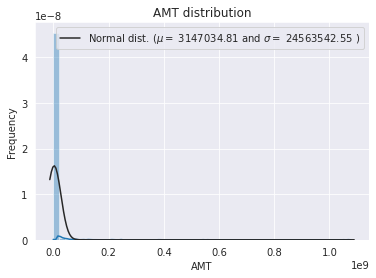

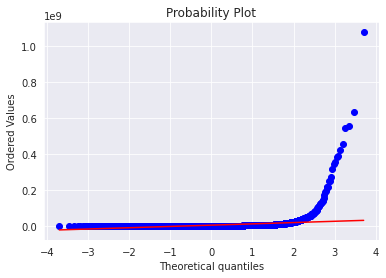

In [ ]:
sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

- 위 결과가 말해주듯이 타겟변수를 정규화 하는 작업이 필요합니다.
- 정규화 작업은 1줄이면 가능합니다.


 mu = 12.71 and sigma = 1.75



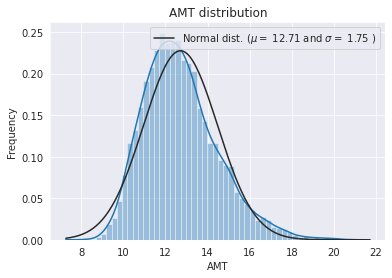

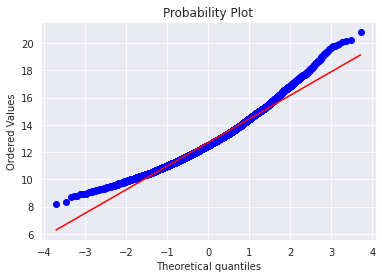

In [ ]:
y_train = np.log1p(y_train)

sns.distplot(y_train , fit=norm);
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('AMT distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

- 로그를 Target값을 변환한 후에 정규분포를 이루는 것을 확인하였습니다.

# V. 교차검증 및 하이퍼 파라미터 튜닝
- 본 장에서는 교차검증을 실시하는 목적과 파라미터 튜닝에 대해 배울 것이다.
## (1) 교차검증의 목적
- 가장 중요한 목적은 과적합(Overfitting)을 방지하기 위해서다.
- 과적합은 무엇인가?
  + 가령, 교고서 범위 내의 있는 문제는 잘 풀지만, 모의고사 또는 수능처럼 약간 응용된 문제가 나오면 잘 풀지 못하는 것과 유사하다.
 + 즉, 고정된 학습데이터와 테스트 데이터로 평가 하다 보니, 테스트 데이터에만 최적의 성능을 발휘할 수 있도록 편향되게 모델이 학습하게 되는 현상을 말한다.
  + 이러한 문제점을 개선하기 위해 교차 검증을 이용해 더 다양한 학습과 평가를 한다.
  + 즉, 본 게임에 앞서서 여러번의 사전 모의평가를 진행하는 것과 유사하다.

## (2) K폴드 교차 검증
- K개의 데이터 세트를 만들고, 검증 평가를 반복적으로 수행하는 방법이다.
- 이 때, 5개의 평가를 평균한 결과를 가지고 예측 성능을 평가한다.

- 기존 처럼, 훈련/테스트 데이터로 분리 한다.
- 그리고, 해당 모델을 처음에 분할하였던 Test Set을 활용하여 평가 한다.
- 층화추출 K폴드도 있다. 데이터의 분포가 불균형을 이룰 때 적용하면 모형의 예측 성능보다는 보다 안정성 있게 모델이 만들어질 수 있다.
  + 참조: Stratified Sampling

## (3) RMSLE 성능 평가 방법
- 회귀 모형의 대표적인 평가 지표이다.
  + RMSLE: Root Mean Square Log Error는 기존 RMSE에 로그를 적용해준 지표다.
- 아쉽게도 sklearn에는 해당 옵션이 제공되지 않기 때문에 RMSLE를 수행하는 성능 평가 함수를 직접 만들어 본다.
- log값 변환 시 NaN등의 이슈로 log가 아닌 log1p()를 이용해 계산한다.
- 이 때, log1p()로 변환된 값은 np.expm1() 함수로 쉽게 원래의 스케일로 복원될 수 있다.

In [ ]:
def rmsle(y, pred): 
  log_y = np.log1p(y)
  log_pred = np.log1p(pred)
  squared_error = (log_y - log_pred)**2
  rmsle = np.sqrt(np.mean(squared_error))
  return print('Test Data RMSLE: {0:.3f}'.format(rmsle))

## (4) 하이퍼 파라미터 및 튜닝
- 1차적으로 모형은 GBM만 사용한다.

- 이 때, 보통 모형 알고리즘에 대한 하이퍼 파라미터 튜닝도 같이 진행하게 된다.

  + n_estimators: weak learner가 순차적으로 오류를 보정함. 개수가 많아지면 성능이 좋아지지만, 수행시간이 오래 발생될 수 있음.
  + learning_rate: 오차를 얼마나 강하게 보정할 것인지 제어
  + max_depth: 복잡도를 너무 높이지 말고 트리의 깊이가 정해진 숫자보다 깊어지지 않게 함.
  + min_samples_leaf: Leaf Node가 되기 위한 최소 샘플 개수
  + loss: huber, 이상치에 민감하지 않도록 보정해주는 함수.
  + max_features: 다차원 독립 변수 중 선택할 차원의 수를 의미함
- 이 때, 보통 최적의 하이퍼 파라미터 튜닝을 위해 값을 조정해서 알고리즘의 예측 성능을 개선한다고 했다.

- GridSearchCV와 RandomizedSearchCV로 구분되는데, 이 부분에 대한 설명은 다음 Chapter에서 진행하도록 한다.

  + 간단하게 설명하면, 파라미터를 순차적으로 변경하면서 최고의 성능을 가지는 파라미터 조합을 찾는 과정이다.

## (5) 세 모델 교차검증
- 지금까지 설명한 내용을 코드로 작성한다.
- 이 때, 최적의 파라미터를 찾기 위한 과정도 추가했다.
- 이제 두개의 모형을 만들어야 한다.
  + 이런 경우에는 모형 선언, 파라미터 지정, 교차검증 수행, 모형 평가 등을 모두 담을 수 있도록 함수화 해야 하는 코드를 작성한다.

##(6) 모형 선언 및 학습

In [ ]:
# 교차검증 수행
def get_best_params_model(model, params):
  cv_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv = 5)
  cv_model.fit(X_train, y_train)
  print("----", model.__class__.__name__, "----")
  print("GridSearchCV 최적 하이퍼 파라미터 :", cv_model.best_params_)

  rmse = np.sqrt(-1*cv_model.best_score_)
  print("GridSearchCV 최적 평균 RMSE값 :", np.round(rmse, 3))

  eval_pred = cv_model.predict(X_test)
  eval_pred = np.expm1(eval_pred)
  rmsle(y_test, eval_pred)
  
  return cv_model.best_estimator_

In [ ]:
from sklearn.linear_model import LinearRegression

# 4개의 모델 선언
xgb = XGBRegressor(random_state=0)
gbm = GradientBoostingRegressor(random_state=0)
lgb = LGBMRegressor(random_state=0)  

params = {'n_estimators': [1000, 2000]}

models = [xgb, gbm, lgb] # 모형 하나 추가 함
best_models = []
for model in models:
  new_model = get_best_params_model(model=model, params=params)
  best_models.append(new_model)

[02:42:00] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:14] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[02:42:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

- 실제 테스트 데이터 셋 모형을 평가한 결과 세 모형을 비교한 결과 각각 []의 값이 나왔다.
- 그러나, 위 평가모형 결과가 실제와 똑같을 거라 생각하면 안된다.
- 다만, 최종 제출폼을 작성하기에 앞서서, 중간에 평가 측정표를 검증하여 마지막 모형을 선정하는 중간 지표로 삼기에는 적절하다.
- 이번에는 stacking model을 사용해야 하기 때문에, 관련 코드를 추가로 작성한다.

## (7) 스태킹 알고리즘 테스트
- 실제 스태킹 알고리즘 테스트를 진행해서, 성능의 차이를 확인해본다.

In [ ]:
# 모형 불러오기
xgb_reg = best_models[0]
gbm_reg = best_models[1]
lgb_reg = best_models[2]

# 예측 데이터 세트
xgb_pred = xgb_reg.predict(X_test)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(X_test)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(X_test)
lgb_pred = np.expm1(lgb_pred)

pred = np.array([xgb_pred, gbm_pred, lgb_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환
pred = np.transpose(pred)
print(pred.shape)

(3, 2863)
(2863, 3)


- 이렇게 예측 데이터로 생성된 데이터 세트를 기반으로 최종 메타 모델을 만든다.

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20
rmsle(y_test, final)

Test Data RMSLE: 1.552


- 위 기준으로 봤을 때는 기존 성능보다 RMSLE기준 보다 성능이 조금 향상되는 것을 확인 할 수 있었다.
- 그러나, 실제로는 어떻게 될지 모르기에 위 코드를 다시한번 적용해보는 코드를 구성해본다.
- 위 작성된 코드를 그대로 사용할 것이다.

## (8) 예측 템플릿 작성
- 예측 템플릿을 작성한다.

In [ ]:
from itertools import product

# 예측 템플릿 만들기
CARD_SIDO_NMs = df_num['CARD_SIDO_NM'].unique()
STD_CLSS_NMs  = df_num['STD_CLSS_NM'].unique()
HOM_SIDO_NMs  = df_num['HOM_SIDO_NM'].unique()
AGEs          = df_num['AGE'].unique()
SEX_CTGO_CDs  = df_num['SEX_CTGO_CD'].unique()
FLCs          = df_num['FLC'].unique()
years         = [2020]
months        = [4, 7]

comb_list = [CARD_SIDO_NMs, STD_CLSS_NMs,HOM_SIDO_NMs, AGEs, SEX_CTGO_CDs, FLCs, years, months]
temp = np.array(list(product(*comb_list)))

train_features = df_num.drop(['CSTMR_CNT', 'AMT', 'CNT'], axis=1)
temp = pd.DataFrame(data=temp, columns=train_features.columns)

In [ ]:
# 예측 데이터 세트
xgb_pred = xgb_reg.predict(temp)
xgb_pred = np.expm1(xgb_pred)

gbm_pred = gbm_reg.predict(temp)
gbm_pred = np.expm1(gbm_pred)

lgb_pred = lgb_reg.predict(temp)
lgb_pred = np.expm1(lgb_pred)

In [ ]:
final = xgb_pred*0.40 + gbm_pred*0.40 + lgb_pred*0.20

temp['AMT'] = np.round(final, 0)
temp['REG_YYMM'] = temp['year']*100 + temp['month']
temp = temp[['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM', 'AMT']]
temp = temp.groupby(['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM']).sum().reset_index(drop=False)

- 라벨 인코딩 했던 부분을 제출을 위해 다시 디코딩하는 작업을 진행한다.

In [ ]:
# 디코딩 
temp['CARD_SIDO_NM'] = encoders['CARD_SIDO_NM'].inverse_transform(temp['CARD_SIDO_NM'])
temp['STD_CLSS_NM'] = encoders['STD_CLSS_NM'].inverse_transform(temp['STD_CLSS_NM'])

In [ ]:
print(temp.head())

   REG_YYMM CARD_SIDO_NM        STD_CLSS_NM           AMT
0    202004           강원         건강보조식품 소매업  8.808981e+08
1    202004           강원            골프장 운영업  1.335067e+09
2    202004           강원        과실 및 채소 소매업  1.741949e+08
3    202004           강원  관광 민예품 및 선물용품 소매업  5.266848e+07
4    202004           강원    그외 기타 스포츠시설 운영업  1.458093e+08


##(9) Submission 파일 작업 및 내보내기

In [ ]:
submission = client.query('''
  SELECT 
    * 
  FROM `cardproject-283503.jeju_data_ver1.submission` 
  ''').to_dataframe()

In [ ]:
submission = submission.drop(['AMT'], axis=1)
submission = submission.merge(temp, left_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], right_on=['REG_YYMM', 'CARD_SIDO_NM', 'STD_CLSS_NM'], how='left')
submission['AMT'] = submission['AMT'].fillna(0)
print(submission.head())

   id  REG_YYMM CARD_SIDO_NM           STD_CLSS_NM           AMT
0   0    202004           강원            건강보조식품 소매업  8.808981e+08
1   1    202004           강원               골프장 운영업  1.335067e+09
2   2    202004           강원           과실 및 채소 소매업  1.741949e+08
3   3    202004           강원     관광 민예품 및 선물용품 소매업  5.266848e+07
4   4    202004           강원  그외 기타 분류안된 오락관련 서비스업  0.000000e+00


In [ ]:
submission.to_csv('submission.csv', encoding='utf-8-sig', index=False)